#Lab 1: Intro to Google Earth Engine

## Introduction

In this lab we will learn how to work with the Google Earth Engine (GEE) python API in Google Colab.
We will explore the GEE environment and see how data is handled by GEE and how to use the GEE tools in Google Colab.

##Imports, installation, authentication, initialization

There are a couple of set-up features that are unique to using Google Earth Engine in Google Colaboratory. Make sure to read through each point to ensure you understand the steps going forward.


1.   GEE has a Javascript API, in which it has a built-in interactive map. In order to visualize our results in the python API, we need to use a special library to load interactive maps. For this course, we will use `geemap` which is based on `ipyleaflet` and `ipywidgets`.
2.   New recently - the geemap library is now automatically installed, so you no longer need to !pip install geemap!  
3.   We need to authenticate and initialize GEE every time we reconnect to an instance using the lines `ee.Authenticate()` and `ee.Initialize()`. Follow the resulting prompts to authenticate in each Colab instance.
4.   Unlike the Javascript API, the python API does not have a console that we can print to, to easily show information about our images and image collections. Instead we need to use `.getInfo()` to print and pprint (pretty printer) to organize the lines to make them easy to read. For more information on `.getInfo()`, see the *Client vs. Server* section of this lab.

There are pros and cons to using both the Javascript API and the python API for Google Earth Engine. One of the major pros of working with the python API is that you don't need to learn Javascript to use it! Another pro is that you can combine GEE code with other remote sensing and raster python libraries to drastically increase how much you can do with the images.

However, the documentation for the python API is much less complete than for the Javascript API and the console is not as interactive.

In our case, the pros outweigh the cons since we have already been working in python, so let's get started!




In [2]:
# Import the necessary libraries
import ee
import numpy as np
import geemap as geemap

import pprint  # I sometimes use this.  Sometimes I just use print.  It is up to you.

# Set up a 'pretty printer' to print dictionaries in a nice format
pp = pprint.PrettyPrinter(depth=4)

In [3]:
# Authenticate and initialize this instance of GEE in Google Colab
## Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize(project='ee-cptcitrus-main')   # you should change this to your project

Enter verification code:  4/1AeanS0Yc_j9xVqSYRfDEdB2RfW0mGV8maGa_DDc18QhdHg7Zrxxu-bly68M



Successfully saved authorization token.


## GEE Data Types

### Client vs. Server

Google Earth Engine works by sending code between your computer in the Python (or JavaScript) API and Google's servers for computation.


There are effectively two types of data structures when we are programming with the GEE Python API:
*   **Client-side structures**: objects and functions that are operating on our own computers.
*   **Server-side structures**: objects and functions that are operating on Google servers

In order to use the server-side structures in our code, the GEE API creates containers, or **proxy objects**, that we can use in our code for the objects that only exist on the Google servers.

We can visualize what this means by considering the following operations:

In [5]:
# Create a local string variable
client_variable = str('Hello!')
print(type(client_variable))

<class 'str'>


In [6]:
# Create a server string variable
server_variable = ee.String('Hello!')
print(type(server_variable))

<class 'ee.ee_string.String'>


These variables contain the same string `Hello!`, but they are packaged and classed differently. The client variable is a value that is stored on our computers, whereas the value in the server variable is stored on the Google server. Let's check more specifically what the difference between these two variables is.

The `isinstance(object,class)` function checks if an object is an instance or subclass of a given class. We will use it to check whether `client_variable` and `server_variable` are some type of string.

In [7]:
# Check whether our variables are string objects
print(isinstance(client_variable, str))
print(isinstance(server_variable, str))

True
False


The class `ee.ee_string.String` isn't a type of string because it is actually a GEE object data type called `ee.ComputedObject`

In [8]:
print(isinstance(server_variable, ee.ComputedObject))

True


The `ee.ComputedObject` is a proxy object of something that exists on the server, but cannot be seen by our computers. You can think of the proxy object as the method of packaging something to be sent to Google. The servers at Google know exactly what is inside, but to our computers it just looks like a box. We use these proxy objects as placeholders in operations.

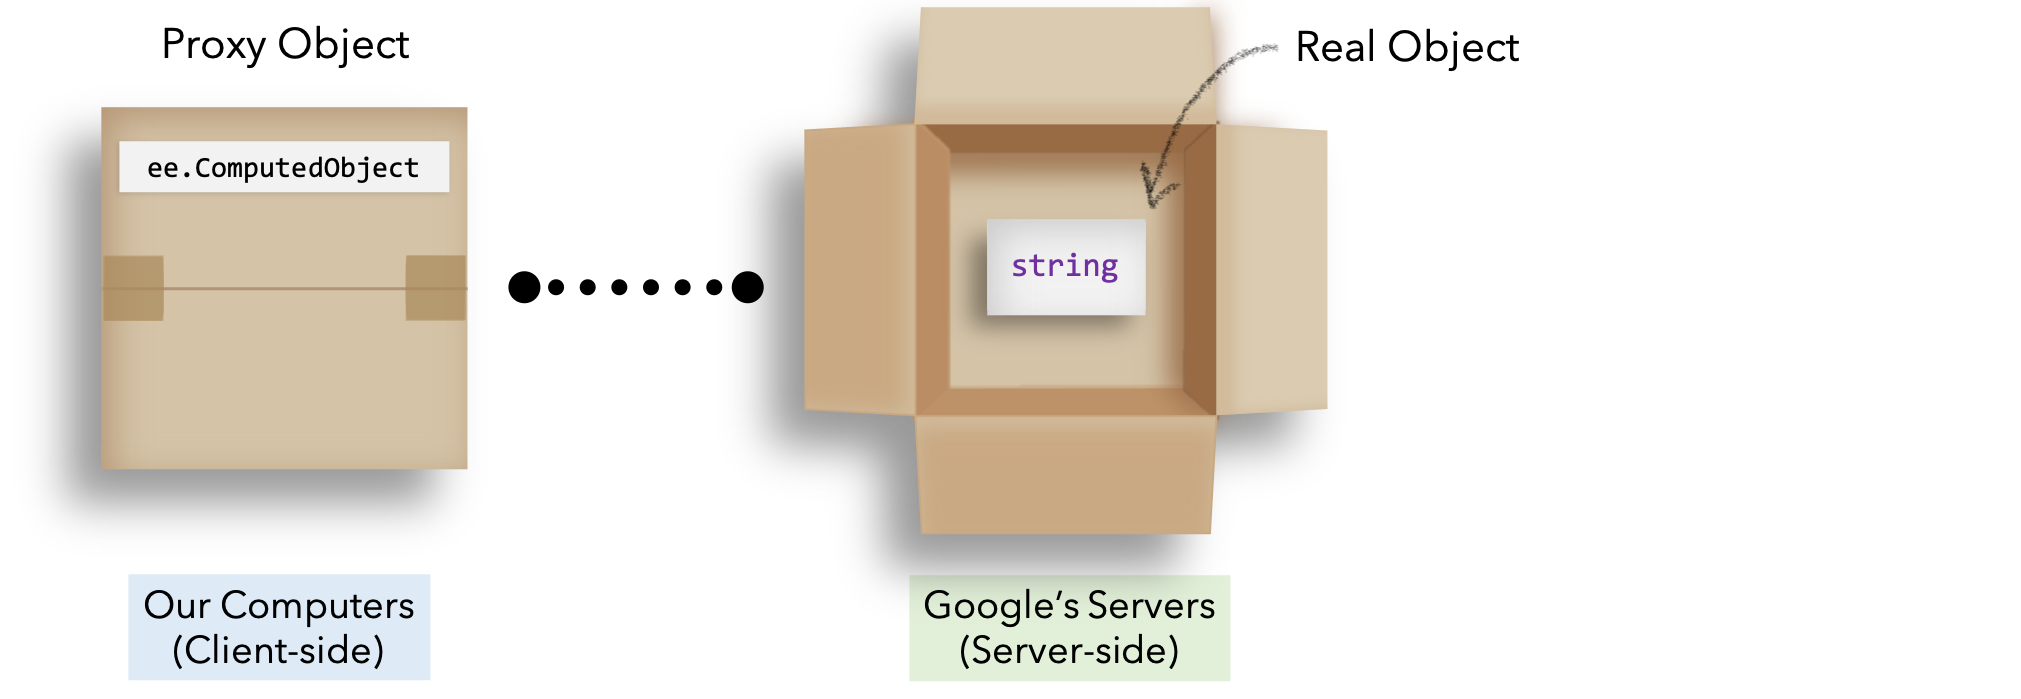

If we need to find out what is inside the container and/or use it in a client side operation, we can use `.getInfo()` to access the contents of the container and assign them to a variable.

Let's try this out some numeric client and server variables.

With a normal integer variable, we could perform a numeric operation:

In [9]:
# Assign the value 8 to a variable
eight = 8

# Add 2 to our variable and print the value
value = eight + 2
print(value)

10


Now let's try the same with a integer server variable:

In [10]:
# Assign the value of 8 to a server-side variable
eight = ee.Number(8)

# Add 2 to our variable and print the value
value = eight + 2
print(value)

TypeError: unsupported operand type(s) for +: 'Number' and 'int'

It doesn't work because `eight` is a proxy object and our computers can't see what is inside.

So let's try the same thing with a `getInfo()` call:

In [11]:
 # Assign the value of 8 to a server-side variable
eight = ee.Number(8)
eight = eight.getInfo()

# Add 2 to our variable and print the value
value = eight + 2
print(value)

10


Now it works because `getInfo()` transferred the contents of the proxy object (in this case the value 8) to a variable on our computers.

*Note that Google warns against using* `.getInfo()`*, in part because it can be slow and because client-side objects cannot be used in server-side operations. See [here](https://developers.google.com/earth-engine/guides/client_server) for more information from Google.*

At this point, it is silly to use an `ee` variable for an integer like 8 because we aren't using it for any server side operations. However, as we go through the course, it will become important to distinguish between server and client structures.

### Data Types

The type of object held by a variable is called its data type or data structure. Recall that some common programming data types include strings, numbers (integers, floats), arrays, lists, dictionaries, etc.

In addition to the common programming data types, Google Earth Engine also has its own data types, including:

*   **Geometry** (vector)
*   **Feature** (vector)
*   **FeatureCollection** (vector)
*   **Image** (raster)
*   **ImageCollection** (raster)



#### Geometry
Geometries are vector data (i.e. points, lines, and polygons) that have no associated attributes or features.

GEE has a number of built in geometry types that you can declare using the coordinates of each vertex:



*   **Point:** `var = ee.Geometry.Point(long,lat)`
*   **Multi-Point:** `var = ee.Geometry.MultiPoint(long1,lat1,long2,lat2,...,longN,latN)`
*   **LineString:** `var = ee.Geometry.LineString([[long1,lat1],[long2,lat2],...,[longN,latN]])`
*   **Rectangle:** `var = ee.Geometry.Rectangle(minLong, minLat, maxLong, maxLat)`
*   **Polygon:** `var = ee.Geometry.Polygon([[long1,lat1],[long2,lat2],...,[longN,latN]])`
*   **Multi-Polygon:** `var = ee.Geometry.MultiPolygon([[[P1_long1,P1_lat1],[P1_long2,P1_lat2],...,[P1_longN,P1_latN]],[[P2_longA,latA],[P2_longB,latB]]...])`


In [12]:
# Create a polygon around Centretown in Ottawa
a = [-75.7123,45.4030]
b = [-75.6840,45.4124]
c = [-75.6807,45.4186]
d = [-75.6999,45.4263]
e = [-75.7098,45.4158]
g = [-75.7214,45.4090]
centretown = ee.Geometry.Polygon([a,b,c,d,e,g])

Once a geometry is created, we can access its properties by calling for them. Let's try just simply printing the object to see what we get:

In [13]:
# Print all the properties of the geometry
print(centretown)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -75.7123,
              45.403
            ],
            [
              -75.684,
              45.4124
            ],
            [
              -75.6807,
              45.4186
            ],
            [
              -75.6999,
              45.4263
            ],
            [
              -75.7098,
              45.4158
            ],
            [
              -75.7214,
              45.409
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})


Yikes - that isn't particularly helpful to us! Recall that our `ee.Geometry.Polygon` is a proxy object, so we cannot simply print our geometry to get the information. Instead, we need to use `.getInfo()` to directly access the contents of our `ee` variables.

In [14]:
# Print all the properties of the geometry (formatted as dictionary)
print(centretown.getInfo())

{'type': 'Polygon', 'coordinates': [[[-75.7123, 45.403], [-75.684, 45.4124], [-75.6807, 45.4186], [-75.6999, 45.4263], [-75.7098, 45.4158], [-75.7214, 45.409], [-75.7123, 45.403]]]}


In [15]:
# Print the coordinates of the geometry
print(centretown.coordinates().getInfo())

[[[-75.7123, 45.403], [-75.684, 45.4124], [-75.6807, 45.4186], [-75.6999, 45.4263], [-75.7098, 45.4158], [-75.7214, 45.409], [-75.7123, 45.403]]]


#### Feature
Features are a vector data type made up of a geometry and attribute information stored in a dictionary.
Any geometry that has information associated with it, like name, object ID, etc. is by definition a feature.

A feature is created by combining a geometry with a dictionary of attributes.

A dictionary in Python is a data structure which stores information in key:value pairs. A dictionary has a order, but is changable. If you are entirely new to Python you may want to do some brief reading about the following Python Data Structures to support your understanding of the scripting methods you will learn in this course: lists, dictionaries, and arrays.

In [16]:
# Create an ee.Geometry.Point at Parliament
parliament_geo = ee.Geometry.Point(-75.699583,45.424820)

# Create a Feature from the Geometry.
parliament_feat = ee.Feature(parliament_geo, {'Name': 'Canada Parliament', 'BuildYear': '1866'});

As with geometries, we can check the properties of our feature.

In [17]:
print(parliament_feat.getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-75.699583, 45.42482]}, 'properties': {'BuildYear': '1866', 'Name': 'Canada Parliament'}}


In [18]:
print(parliament_feat.geometry().getInfo())

{'type': 'Point', 'coordinates': [-75.699583, 45.42482]}


In [19]:
print(parliament_feat.geometry().coordinates().getInfo())

[-75.699583, 45.42482]


In [20]:
print(parliament_feat.propertyNames().getInfo())

['BuildYear', 'Name']


 Now that we have a number of properties, we can access them using the `.get(property)` function, where `property` is the name of the properties we set.

In [21]:
print(parliament_feat.get('Name').getInfo())

Canada Parliament


#### Feature Collection

Feature collections are groupings of related features stored in a single dataset. By grouping features together, it allows for sorting and filtering. Unlike something like a shapefile, not all of the features in a feature collection need to have the same geometry; for example, you can have a feature collection that contains a rectangle, a line, and a point.



In [22]:
# Create a feature for the U.K. Parliament building
uk_parliament = ee.Feature(ee.Geometry.Point(-0.125,51.499),{'Name': 'UK Parliament', 'BuildYear': '1016'})

# Create a list of our two parliament features
parliaments_list = [parliament_feat,uk_parliament]

# Create a FeatureCollection from the list and print it.
parliaments_fc = ee.FeatureCollection(parliaments_list)
print(parliaments_fc.getInfo())

{'type': 'FeatureCollection', 'columns': {'BuildYear': 'String', 'Name': 'String', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-75.699583, 45.42482]}, 'id': '0', 'properties': {'BuildYear': '1866', 'Name': 'Canada Parliament'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-0.125, 51.499]}, 'id': '1', 'properties': {'BuildYear': '1016', 'Name': 'UK Parliament'}}]}


You can also use feature collection properties to access specific features. For example, we can filter our feature collection to give just the feature with the name "Canada Parliament"

In [23]:
# Filter feature collection by feature name
ca_parl = parliaments_fc.filter(ee.Filter.inList('Name', ['Canada Parliament']))

# Use pretty printer to print the results
pp.pprint(ca_parl.getInfo())

{'columns': {'BuildYear': 'String', 'Name': 'String', 'system:index': 'String'},
 'features': [{'geometry': {'coordinates': [...], 'type': 'Point'},
               'id': '0',
               'properties': {'BuildYear': '1866', 'Name': 'Canada Parliament'},
               'type': 'Feature'}],
 'type': 'FeatureCollection'}


#### Image

Images are the basic raster format in Google Earth Engine. Images are composed of one or more bands. Each image contains a set of properties to hold their metadata.

In [30]:
# Assign a Landsat 8 ee.Image object to a variable
# Images all have an image ID
## in this case we are calling for a Landsat 8 surface reflectance image from 11 June 2020
L8_image = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_015028_20200611')

As with features, you can access the properties of an image by using the `.get()` and `.getInfo()` operators

In [31]:
# Print the image
print(L8_image.getInfo())

# We can use the pretty printer library to print the dictionary in an accessible way
pp.pprint(L8_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7791, 7901], 'crs': 'EPSG:32618', 'crs_transform': [30, 0, 425385, 0, -30, 5215515]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7791, 7901], 'crs': 'EPSG:32618', 'crs_transform': [30, 0, 425385, 0, -30, 5215515]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7791, 7901], 'crs': 'EPSG:32618', 'crs_transform': [30, 0, 425385, 0, -30, 5215515]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7791, 7901], 'crs': 'EPSG:32618', 'crs_transform': [30, 0, 425385, 0, -30, 5215515]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7791, 7901], 'crs': 'EPSG:32618', 'crs_transform': [30, 0, 425385, 0, -30

In [32]:
# Get the property names of an image
img_props = L8_image.propertyNames().getInfo()
print(img_props)

['DATA_SOURCE_ELEVATION', 'WRS_TYPE', 'system:id', 'REFLECTANCE_ADD_BAND_1', 'REFLECTANCE_ADD_BAND_2', 'DATUM', 'REFLECTANCE_ADD_BAND_3', 'REFLECTANCE_ADD_BAND_4', 'REFLECTANCE_ADD_BAND_5', 'REFLECTANCE_ADD_BAND_6', 'REFLECTANCE_ADD_BAND_7', 'system:footprint', 'REFLECTIVE_SAMPLES', 'system:version', 'GROUND_CONTROL_POINTS_VERSION', 'SUN_AZIMUTH', 'DATA_SOURCE_TIRS_STRAY_LIGHT_CORRECTION', 'UTM_ZONE', 'DATE_ACQUIRED', 'ELLIPSOID', 'system:time_end', 'DATA_SOURCE_PRESSURE', 'LANDSAT_PRODUCT_ID', 'STATION_ID', 'TEMPERATURE_ADD_BAND_ST_B10', 'DATA_SOURCE_REANALYSIS', 'REFLECTANCE_MULT_BAND_7', 'system:time_start', 'REFLECTANCE_MULT_BAND_6', 'L1_PROCESSING_LEVEL', 'PROCESSING_SOFTWARE_VERSION', 'L1_DATE_PRODUCT_GENERATED', 'ORIENTATION', 'REFLECTANCE_MULT_BAND_1', 'WRS_ROW', 'REFLECTANCE_MULT_BAND_3', 'REFLECTANCE_MULT_BAND_2', 'TARGET_WRS_ROW', 'REFLECTANCE_MULT_BAND_5', 'REFLECTANCE_MULT_BAND_4', 'THERMAL_LINES', 'TIRS_SSM_POSITION_STATUS', 'GRID_CELL_SIZE_THERMAL', 'IMAGE_QUALITY_TIRS',

In [33]:
# Get the image ID
print(L8_image.id().getInfo())

# Get the names of bands in the image
print(L8_image.bandNames().getInfo())

LC08_015028_20200611
['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']


In [34]:
# Get the property names of an image
print(L8_image.propertyNames().getInfo())

['DATA_SOURCE_ELEVATION', 'WRS_TYPE', 'system:id', 'REFLECTANCE_ADD_BAND_1', 'REFLECTANCE_ADD_BAND_2', 'DATUM', 'REFLECTANCE_ADD_BAND_3', 'REFLECTANCE_ADD_BAND_4', 'REFLECTANCE_ADD_BAND_5', 'REFLECTANCE_ADD_BAND_6', 'REFLECTANCE_ADD_BAND_7', 'system:footprint', 'REFLECTIVE_SAMPLES', 'system:version', 'GROUND_CONTROL_POINTS_VERSION', 'SUN_AZIMUTH', 'DATA_SOURCE_TIRS_STRAY_LIGHT_CORRECTION', 'UTM_ZONE', 'DATE_ACQUIRED', 'ELLIPSOID', 'system:time_end', 'DATA_SOURCE_PRESSURE', 'LANDSAT_PRODUCT_ID', 'STATION_ID', 'TEMPERATURE_ADD_BAND_ST_B10', 'DATA_SOURCE_REANALYSIS', 'REFLECTANCE_MULT_BAND_7', 'system:time_start', 'REFLECTANCE_MULT_BAND_6', 'L1_PROCESSING_LEVEL', 'PROCESSING_SOFTWARE_VERSION', 'L1_DATE_PRODUCT_GENERATED', 'ORIENTATION', 'REFLECTANCE_MULT_BAND_1', 'WRS_ROW', 'REFLECTANCE_MULT_BAND_3', 'REFLECTANCE_MULT_BAND_2', 'TARGET_WRS_ROW', 'REFLECTANCE_MULT_BAND_5', 'REFLECTANCE_MULT_BAND_4', 'THERMAL_LINES', 'TIRS_SSM_POSITION_STATUS', 'GRID_CELL_SIZE_THERMAL', 'IMAGE_QUALITY_TIRS',

In [35]:
# Get a particular property of the image by property name
print(L8_image.get('CLOUD_COVER').getInfo())

74.56


We can also use a handy function from the `geemap` library that allows us to print out all of the properties of an image

In [36]:
# Explore all of the properties of the image
imageprops = geemap.image_props(L8_image)
imageprops.getInfo()

{'ALGORITHM_SOURCE_SURFACE_REFLECTANCE': 'LaSRC_1.5.0',
 'ALGORITHM_SOURCE_SURFACE_TEMPERATURE': 'st_1.3.0',
 'CLOUD_COVER': 74.56,
 'CLOUD_COVER_LAND': 75.23,
 'COLLECTION_CATEGORY': 'T1',
 'COLLECTION_NUMBER': 2,
 'DATA_SOURCE_AIR_TEMPERATURE': 'MODIS',
 'DATA_SOURCE_ELEVATION': 'GLS2000',
 'DATA_SOURCE_OZONE': 'MODIS',
 'DATA_SOURCE_PRESSURE': 'Calculated',
 'DATA_SOURCE_REANALYSIS': 'GEOS-5 FP-IT',
 'DATA_SOURCE_TIRS_STRAY_LIGHT_CORRECTION': 'TIRS',
 'DATA_SOURCE_WATER_VAPOR': 'MODIS',
 'DATE_ACQUIRED': '2020-06-11',
 'DATE_PRODUCT_GENERATED': 1598304184000,
 'DATUM': 'WGS84',
 'EARTH_SUN_DISTANCE': 1.0154524,
 'ELLIPSOID': 'WGS84',
 'GEOMETRIC_RMSE_MODEL': 7.274,
 'GEOMETRIC_RMSE_MODEL_X': 5.14,
 'GEOMETRIC_RMSE_MODEL_Y': 5.147,
 'GEOMETRIC_RMSE_VERIFY': 5.9,
 'GRID_CELL_SIZE_REFLECTIVE': 30,
 'GRID_CELL_SIZE_THERMAL': 30,
 'GROUND_CONTROL_POINTS_MODEL': 169,
 'GROUND_CONTROL_POINTS_VERIFY': 56,
 'GROUND_CONTROL_POINTS_VERSION': 5,
 'IMAGE_DATE': '2020-06-11',
 'IMAGE_QUALITY_OLI'

#### Image Collection

An image collection is a grouping, or stack, of images. Image collections can be sorted, filtered, and reduced (i.e. summarized).

In [40]:
# Assign your image collection of choice to a variable
# The GEE data catalog provides the string used to code for each dataset
# For landsat 8, the string is "LANDSAT/LC08/C01/T1_SR"
L8_SR = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")

# Similarly, to import the Landsat 7 top of atmosphere collection, we use:
L7_TOA = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")

This `L8_SR` variable corresponds to the entire Landsat 8 Surface Reflectance Tier 1 collection. Let's get an idea of how many images that is (warning: this may take a while to run)

In [39]:
#print(L8_SR.size().getInfo()) #DOES NOT RUN , too large

KeyboardInterrupt: 

That code tells us that we have over a million individual Landsat tiles stored in our `L8_SR` variable. For most purposes, we would not want to deal with that many images, which is where filtering comes in handy.

**There are a couple of different ways to filter an image collection:**


*   By date
*   By location
*   By an image property



In [41]:
# Filter by date range
L8_SR_Summer2020 = L8_SR.filterDate('2020-06-01', '2020-08-31')

# Filter by multiple date ranges
L8_SR_Summers20192020 = L8_SR.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date('2020-06-01', '2020-08-31')),
                  ee.Filter.And(ee.Filter.date('2019-06-01', '2019-08-31'))))

# Check the number of images in our new collections
print(L8_SR_Summer2020.size().getInfo())
print(L8_SR_Summers20192020.size().getInfo())


46450
93034


By filtering our collection by date, we not only significantly reduced the number of images in the collection, but we also focused the collection on a time period that is useful to us.

Now lets filter our collection even more.

In [42]:
# Create a point from coordinates
uOttawa = ee.Geometry.Point([-75.683187,45.423050])

# Filter the collection to only images that overlap with our point
# Note that we are filtering the L8_SR_Summer2020 collection, which already has only ~43,000 images
L8_SR_Summer2020_uOttawa = L8_SR_Summer2020.filterBounds(uOttawa)

# Check how many images we have
print(L8_SR_Summer2020_uOttawa.size().getInfo())

15


So there are 14 Landsat 8 Surface Reflectance images over uOttawa for the summer of 2020. However, some of these may have clouds and be unusable.

Let's now limit our collection only to the most usable images using the image property "CLOUD_COVER"

In [43]:
# Filter collection for images with cloud cover less than 70%
# There are 2 ways to do this:

# use .filter
L8_SR_Summer2020_uOttawa_cf1 = L8_SR_Summer2020_uOttawa.filter(ee.Filter.lt('CLOUD_COVER',70))

# use filterMetaData
L8_SR_Summer2020_uOttawa_cf2 = L8_SR_Summer2020_uOttawa.filterMetadata('CLOUD_COVER', "less_than", 70)

# Check how many images we have
print(L8_SR_Summer2020_uOttawa_cf1.size().getInfo())
print(L8_SR_Summer2020_uOttawa_cf2.size().getInfo())

9
9


Both of those methods give us the same results: there are 9 Landsat 8 Surface Reflectance images over uOttawa for the summer of 2020 with cloud cover less than 70%.

There are many other ways we can filter an image collection. Scroll through the filter documentation in the [API docs guide](https://developers.google.com/earth-engine/api_docs#eefilter) to explore different ways of filtering. You can also explore the different functions (including filtering functions) by checking out the client libraries section (on the left hand side) of [GEE's documentation guides](https://developers.google.com/earth-engine/apidocs/ee-filter)


We can also sort our image collection by its metadata.

In [44]:
# Sort the image collection by cloud cover
L8_SR_Summer2020_uOttawa_cf2 = L8_SR_Summer2020_uOttawa_cf2.sort("CLOUD_COVER")

# Choose the least cloudy image
# This step assigns the least cloud image to a variable
uOttawa_L8SR_Sum2020_img = L8_SR_Summer2020_uOttawa_cf2.first()

`L8_SR_Summer2020_uOttawa_cf2` is an ***image collection*** sorted from least cloudy to most cloudy.

`uOttawa_L8SR_Sum2020_img` is the least cloudy ***image*** from that collection



## Create interactive maps

### `geemap` Library

Now that we have seen the different data types, it is time to start adding things to the map!

As described in the imports section at the beginning of this lab, we need to use a special library to create maps when working with the python API. The easiest way to create these maps is with the `geemap` library which is based on `ipyleaflet` and `ipywidgets`.

When using the geemap library to examine imagery, there are a couple of quirks we need to get used to.

The first quirk is that we need to first tell the computer that we want to plot things on a map by creating a map object.

The map object will be assigned to a variable and can have any name you want (just like other variables). Try to name it something that makes sense, like, `Map`.

In [45]:
Map = geemap.Map()

Note that the above code doesn't produce anything - all we have done is assign a map object to a variable. If we want to explore our map, we need to call for it.

In [46]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

We can explore this map by zooming in and moving it around. It currently has two layers: Google Maps and its basemap, Open Street Map, but in order to play around with the layers, we need to explicitly tell our map that we want to do that.

In [47]:
Map.addLayerControl()

Whenever we do something to our map in Google Colab, we need to call for it again.

In [48]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Now we have a little button in the top right corner that allows us to change the layers we see. Currently our only options are to toggle Google Maps on and off, but as we add more layers to our map, the `Map.addLayerControl()` function will be useful.

Note that `Map` in this case is the variable we assigned our map object to. If you named your map object `My_cute_map_1` then you need to call `My_cute_map_1.addLayerControl()`.

### Visualizing Layers


To add a layer to a map, we use the `Map.addLayer()` function. This function takes 5 inputs but only the first is required. The other arguments only need to be specified if you don't want to use the defaults.



`Map.addLayer(eeObject, visParams, name, shown, opacity)`

**Where:**


`eeObject` = the object you want to add, usually either an image or a geometry

`visParams` = the visualization parameters used to display the object, see more description below.

`name` =  the name you want shown beside the layer on the map. Default is 'Layer N'

`shown` = **True** (layer is automatically on) or **False** (layer is off). Default is **True**

`opacity` = number between 0 (transparent) and 1 (fully opaque). Default is 1



The visualization parameters have many options
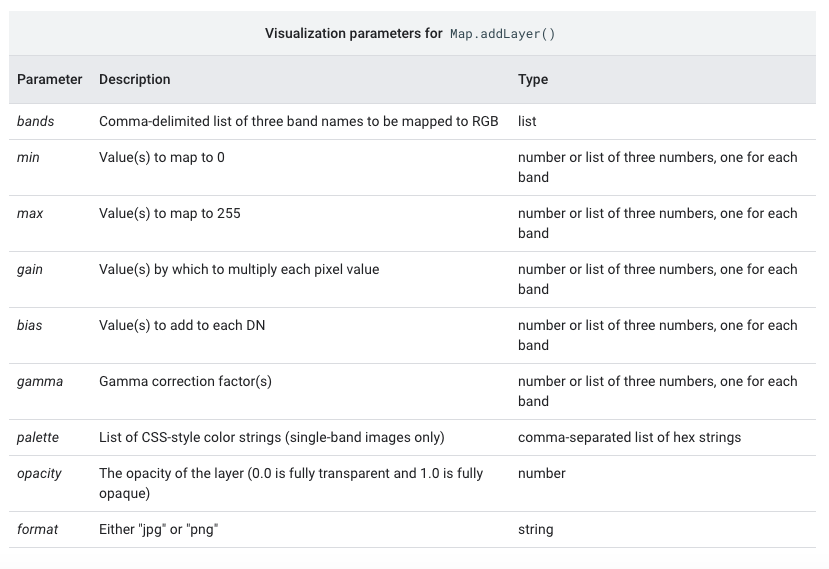


The visualization parameters are set up within curly brackets (braces) with the following set up:



In [49]:
visParams = {
 'bands': ['B4', 'B3', 'B2'],# band order corresponds to R G B visualization channels
 'min': 0,
 'max': 5000
 # etc. with the other parameters
 }

There are also two main ways to set the map view, so that we don't have to drag and zoom in to see our layer. Zoom level goes from 1 (super zoomed out) to 24 (super zoomed in).


`Map.setCenter(longitude,latitude,zoomlevel)`

and

`Map.centerObject(object,zoomlevel)`

##Working with datasets in GEE

There are three primary ways of working with datasets in GEE:
- Load a dataset from the GEE catalogue
- Load a dataset from local/google drive
- Define your own feature/geometry/raster

Most often when working with raster data, we load a dataset from the GEE catalogue because the catalogue is extensive and it is the easiest way of working with large amounts of raster data in GEE. Image having to manage 1 million+ ~500MB images on your personal computer!

With vector data, all three options are relatively easy. This allows for a lot of flexibility to use specific vector datasets -- or to define polygons in your code -- to use with the raster data from the GEE catalogue.

### As we go through the course, we will combine the use of different datasets to manipulate and analyze data. For now, let's look at how to load and visualize some common datasets.




### GEE Catalog

Google Earth Engine allows you to add any datasets and imagery from their [data catalog](https://developers.google.com/earth-engine/datasets). I encourage you to explore the datasets they have available. Their catalog does an excellent job of summarizing the data and providing example code for how to import the imagery into GEE.

### Landsat

Landsat is one of the most commonly used datasets in the Google Earth Engine catalog. Data from Landsat 1-8 are available in a variety of formats: raw DN, surface reflectance, TOA reflectance, and as computed products such as vegetation indices. [The various Landsat image collections are grouped together for easy access in the GEE Catalog](https://developers.google.com/earth-engine/datasets/catalog/landsat). Note that Tier 1 and Tier 2 refers to the quality of the image collection where Tier 1 have the highest radiometric and postitional quality. For more information, check out this [video](https://www.usgs.gov/media/videos/landsat-collections-what-are-tiers), from the USGS.

Working with Landsat imagery follows the same basic pattern across the collections. To start, we will work with the Landsat 5 SR collection.

We will filter the L5 SR image collection in the same way as we did earlier with L8, and then find an image to add by name/ID.

In [51]:
# Filter Landsat 5 SR collection to images over CarletonU Summer 2011
# Note that the slashes \ at the end of the lines allow the code to carry to the next line

CarletonU = ee.Geometry.Point(-75.69,45.38)

L5_Carleton_S2020 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                              .filterBounds(CarletonU)\
                              .filterDate('2011-06-01', '2011-08-31')

# Print the size of the collection
print(L5_Carleton_S2020.size().getInfo())

#Note 2 - later in the semester we will use Landsat collection 2.  There are a few differences in band names and metadata info between the two collections.

18


In [52]:
# Get a list of all the image names in our collection
imagenames = L5_Carleton_S2020.aggregate_array('system:id') # the Landsat id is stored under the 'system:id' property

# You can either print it normally
print("List of images: ",imagenames.getInfo())

# or use pretty printer to get a vertical list
pp.pprint(imagenames.getInfo())

List of images:  ['LANDSAT/LT05/C02/T1_L2/LT05_015028_20110603', 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110619', 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110705', 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110721', 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110806', 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110822', 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110603', 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110619', 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110705', 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110721', 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110806', 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110822', 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110610', 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110626', 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110712', 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110728', 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110813', 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110829']
['LANDSAT/LT05/C02/T1_L2/LT05_015028_20110603',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110619',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_201

In [53]:
L5_Carleton_S2020.sort("CLOUD_COVER")
imagenames = L5_Carleton_S2020.aggregate_array('system:id') # the Landsat id is stored under the 'system:id' property
pp.pprint(imagenames.getInfo())


['LANDSAT/LT05/C02/T1_L2/LT05_015028_20110603',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110619',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110705',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110721',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110806',
 'LANDSAT/LT05/C02/T1_L2/LT05_015028_20110822',
 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110603',
 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110619',
 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110705',
 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110721',
 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110806',
 'LANDSAT/LT05/C02/T1_L2/LT05_015029_20110822',
 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110610',
 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110626',
 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110712',
 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110728',
 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110813',
 'LANDSAT/LT05/C02/T1_L2/LT05_016028_20110829']


We can call for a specific image in the GEE catalog by using it's ID. To test this out, we can use one of the IDs listed above.

In [69]:
# Load the last image in the collection
L5_2011Aug29 = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016028_20110829')

# Explore the properties of the image
imageprops = geemap.image_props(L5_2011Aug29)
imageprops.getInfo()

{'ALGORITHM_SOURCE_SURFACE_REFLECTANCE': 'LEDAPS_3.4.0',
 'ALGORITHM_SOURCE_SURFACE_TEMPERATURE': 'st_1.3.0',
 'CLOUD_COVER': 24,
 'CLOUD_COVER_LAND': 24,
 'COLLECTION_CATEGORY': 'T1',
 'COLLECTION_NUMBER': 2,
 'CORRECTION_BIAS_BAND_1': 'CPF',
 'CORRECTION_BIAS_BAND_2': 'CPF',
 'CORRECTION_BIAS_BAND_3': 'CPF',
 'CORRECTION_BIAS_BAND_4': 'CPF',
 'CORRECTION_BIAS_BAND_5': 'CPF',
 'CORRECTION_BIAS_BAND_6': 'CPF',
 'CORRECTION_BIAS_BAND_7': 'CPF',
 'CORRECTION_GAIN_BAND_1': 'CPF',
 'CORRECTION_GAIN_BAND_2': 'CPF',
 'CORRECTION_GAIN_BAND_3': 'CPF',
 'CORRECTION_GAIN_BAND_4': 'CPF',
 'CORRECTION_GAIN_BAND_5': 'CPF',
 'CORRECTION_GAIN_BAND_6': 'INTERNAL_CALIBRATION',
 'CORRECTION_GAIN_BAND_7': 'CPF',
 'DATA_SOURCE_AIR_TEMPERATURE': 'NCEP',
 'DATA_SOURCE_ELEVATION': 'GLS2000',
 'DATA_SOURCE_OZONE': 'TOMS',
 'DATA_SOURCE_PRESSURE': 'NCEP',
 'DATA_SOURCE_REANALYSIS': 'GEOS-5 FP-IT',
 'DATA_SOURCE_WATER_VAPOR': 'NCEP',
 'DATA_TYPE_L0RP': 'TMR_L0RP',
 'DATE_ACQUIRED': '2011-08-29',
 'DATE_PRODUCT_

The above code returns all of the associated metadata from an image. From this, we can see that the image has 24% cloud cover, that it has 11 bands, including 3 quality bands, and that it was taken on August 29th, 2011 at 3:39PM, among other things.

In [76]:
Map = geemap.Map()
# Centre the map on the point
Map.centerObject(CarletonU, 11)

# # Define a function to apply scaling factors
# def apply_scale_factors(image):
#     optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
#     thermal_band = image.select('ST_B6').multiply(0.00341802).add(149.0)
#     return image.addBands(optical_bands, None, True) \
#                 .addBands(thermal_band, None, True)

# L5_2011Aug29 = L5_2011Aug29.map(apply_scale_factors);

# Here we set it up so that band3 is in Red, B2 is in Green, and B1 is in Blue (true colour)
visParams = {
  'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
  'min': 0,
  'max': 30000,
};

# Add the scene to the map with the visualization parameters created above
Map.addLayer(L5_2011Aug29, visParams,"Carleton 2011Aug29")
Map.addLayerControl()

#Done!  now you can zoom/pan and look at the image you have requested.
Map

Map(center=[45.38, -75.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

#### Cloud masking

Our image is pretty good but as we saw in the image properties (and as we can see on the map), the image has 24.5% cloud cover.

There are a couple of ways to get around the clouds. Instead of using the last image in our image collection, we could instead sort it to get the least cloudy image.


In [77]:
# Sort the collection by cloud cover and then take the first (the least cloudy)
leastcloudy = L5_Carleton_S2020.sort('CLOUD_COVER').first()

# Check how much cloud cover the least cloudy image has
imageprops = geemap.image_props(leastcloudy)
print(imageprops.get('CLOUD_COVER').getInfo())

0


This is great if we aren't picky about the date or we just want to take a quick look at the area but if we need to analyze the image, we will need to mask out the clouds.

There are several different ways to mask clouds, and different options for each sensor. For Landsat, one useful method to mask out clouds is by using the pixel quality assurance band. The quality assurance band `pixel_qa` contains information about the quality of each pixel. These methods select any pixels that are “bad” and mask them out.

If you're interested and want more information on how the qa bands work, check out [this](https://www.google.com/url?q=https://www.usgs.gov/land-resources/nli/landsat/landsat-sr-derived-spectral-indices-pixel-quality-band&sa=D&source=editors&ust=1613500103309000&usg=AOvVaw0ZJKTwxW03RKzPTPRUYO4r) and [this](https://hyspeedblog.wordpress.com/2014/08/27/working-with-landsat-8-using-and-interpreting-the-quality-assessment-qa-band/).

For now, it's not super necessary to understand how this function works. The cloud mask functions used in this lab were taken directly from the Google example scripts (see the end of [this page](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR) to find the L8 cloud masking function).


In [81]:
# Create a function to mask out clouds in Landsat 8 images
## This one is taken from GEE example scripts

def cloudMask(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3 #select the cloud shadow bit location
  cloudsBitMask = 1 << 5 # select the cloud bit location
  # Get the pixel QA band.
  qa = image.select('QA_PIXEL')
  # Both flags should be set to zero, indicating clear conditions.
  # this only keeps pixels were both the cloud and cloud shadow bits are set to 0
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  # Return the masked image, not scaled to reflectance, with the QA bands.
  return image.updateMask(mask)

We can run this function on a single image, or 'map' it across an entire image collection. In the latter case, the function is applied to every single image in the image collection. This is useful if later you want to reduce a stack of images into a single image composite or an image mosaic (which we will do in another lab!)

In [82]:
# On a single image
cloudfree_img = cloudMask(L5_2011Aug29)

# On an image collection
cloudfree_imgcol = L5_Carleton_S2020.map(cloudMask)

Check out what the cloud masked image looks like

In [83]:
Map = geemap.Map()
Map.addLayer(cloudfree_img,visParams)
Map.centerObject(CarletonU,11)
Map.addLayerControl()
Map

Map(center=[45.38, -75.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

When we apply the cloud mask to the image collection, the same operation occurs to each image in that image collection. If we were to call to visualize the first image in our cloud masked image collection, we would see the same spots of missing imagery where clouds used to be.

In [84]:
Map = geemap.Map()
Map.addLayer(cloudfree_imgcol.first(),visParams)
Map.centerObject(CarletonU,12)
Map.addLayerControl()
Map

# this time, the original image didn't have very many clouds - but what was there are now masked out
# we can see some of these spots over the Ottawa River and over the neighbourhood in the bottom right on the map

Map(center=[45.38, -75.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### Sentinel

The Sentinel satellites are a part of the Copernicus program run by the European Commission and the European Space Agency. The Copernicus program includes radar images from Sentinel-1A and 1B, high-resolution optical images from Sentinel-2A and 2B, ocean and land data suitable for environmental and climate monitoring from Sentinel-3, as well as air quality data from Sentinel-5P.

#### Sentinel-1 SAR

Sentinel-1 collects C-band synthetic aperture radar (SAR) imagery. Data is collected in a variety of ways and requires quite a bit of filtering of the metadata to visualize or process. For more information on Sentinel-1, check out the GEE resource [here](https://developers.google.com/earth-engine/guides/sentinel1).

In [158]:
# Set a point in Churchill, Manitoba
churchill = ee.Geometry.Point(-94.13, 58.78)

# Filter Sentinel 1 Collection by metadata properties
## Filter to get images with VV polarization
## Filter to get images collected in interferometric wide swath mode
## Filter to get images in ascending orbit
s1_col =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by and location
s1_img = s1_col.filterBounds(churchill)\
                  .filterDate('2018-04-01','2019-05-31')\
                  .first()# Choose first image in collection

# Print image properties
imageprops = geemap.image_props(s1_img)
imageprops.getInfo()

{'GRD_Post_Processing_facility_country': 'Germany',
 'GRD_Post_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA',
 'GRD_Post_Processing_facility_org': 'ESA',
 'GRD_Post_Processing_facility_site': 'DLR-Oberpfaffenhofen',
 'GRD_Post_Processing_software_name': 'Sentinel-1 IPF',
 'GRD_Post_Processing_software_version': '002.90',
 'GRD_Post_Processing_start': 1523080015680,
 'GRD_Post_Processing_stop': 1523080675000,
 'IMAGE_DATE': '2018-04-06',
 'NOMINAL_SCALE': {'VH': 10, 'VV': 10, 'angle': 16275.121203055469},
 'S1TBX_Calibration_vers': '6.0.4',
 'S1TBX_SAR_Processing_vers': '6.0.4',
 'SLC_Processing_facility_country': 'Germany',
 'SLC_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA',
 'SLC_Processing_facility_org': 'ESA',
 'SLC_Processing_facility_site': 'DLR-Oberpfaffenhofen',
 'SLC_Processing_software_name': 'Sentinel-1 IPF',
 'SLC_Processing_software_version': '002.90',
 'SLC_Processing_start': 1523080131000,
 'SLC_Processing_stop': 152308045700

In [86]:
# Display image on map
Map = geemap.Map()
Map.centerObject(churchill,8)
Map.addLayer(s1_img, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image')
Map

Map(center=[58.78000000000001, -94.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

#### Sentinel-2 MSI

The S2 Multispectral Instrument (MSI) has 13 spectral bands at different resolutions: R, G, B, and NIR at 10m, red edge and SWIR at 20m, and atmospheric bands at 60m spatial resolution. Data is available as both TOA Reflectance and atmospherically corrected Surface Reflectance products.

Let's filter the Sentinel-2 surface reflectance collection and visualize an image to start.

In [87]:
# Create a point in Lethbridge, Alberta
lethbridge = ee.Geometry.Point([-112.8388,49.6967])

# Load all Sentinel 2 Surface Reflectance images from April 2019 over Lethbridge
## Note that the cloud cover property name is different than Landsat
AllApril2019 = ee.ImageCollection('COPERNICUS/S2_SR')\
                  .filterDate('2019-04-01', '2019-05-01')\
                  .filterBounds(lethbridge)\
                  .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',30))\
                  .sort('CLOUDY_PIXEL_PERCENTAGE')\
                  .first()

# Get the properties of the image
imageprops = geemap.image_props(AllApril2019)
imageprops.getInfo()

{'AOT_RETRIEVAL_ACCURACY': 0,
 'CLOUDY_PIXEL_PERCENTAGE': 8.888204,
 'CLOUD_COVERAGE_ASSESSMENT': 8.888204,
 'CLOUD_SHADOW_PERCENTAGE': 0.017031,
 'DARK_FEATURES_PERCENTAGE': 0.496362,
 'DATASTRIP_ID': 'S2B_OPER_MSI_L2A_DS_MTI__20190422T233814_S20190422T184004_N02.11',
 'DATATAKE_IDENTIFIER': 'GS2B_20190422T183929_011107_N02.11',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1555976294000,
 'GEOMETRIC_QUALITY': 'PASSED',
 'GRANULE_ID': 'L2A_T12UUA_A011107_20190422T184004',
 'HIGH_PROBA_CLOUDS_PERCENTAGE': 0.074159,
 'IMAGE_DATE': '2019-04-22',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 288.554510619,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 287.50847566,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 287.967241664,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 288.38551665,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 287.07461629,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 287.381346297,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4': 287.7

Now let's add this image to the map to see what it looks like. Note the strange shape of the image on the map!

In [88]:
# Set the visualization parameters for the image
visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000
}

Map2 = geemap.Map() # Create map object
Map2.centerObject(AllApril2019, zoom=8)
Map2.addLayer(AllApril2019,visParams)
Map2 # Display the map

Map(center=[50.074956810039744, -113.21323728476597], controls=(WidgetControl(options=['position', 'transparen…

Cloud masking with Sentinel is very similar to Landsat. This function was taken directly from the [GEE example code snippets](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR).

In [89]:
# This example uses the Sentinel-2 QA band to cloud mask the collection.
# The Sentinel-2 cloud flags are less selective, so the collection is also pre-filtered by the
## CLOUDY_PIXEL_PERCENTAGE flag, to use only relatively cloud-free granule.

# Function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
  qa = image.select('QA60')
  #Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  #Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  #Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask)

# Map the function over one year of data and take the median.
# Load Sentinel-2 TOA reflectance data.
collection = ee.ImageCollection('COPERNICUS/S2')\
    .filterDate('2016-01-01', '2016-12-31')\
    .filterBounds(lethbridge)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .map(maskS2clouds)\
    .first()

# Display the results.
Map = geemap.Map()
Map.centerObject(collection,12)
Map.addLayer(collection, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'RGB')
Map

Map(center=[50.01341131966518, -113.46065433995241], controls=(WidgetControl(options=['position', 'transparent…

### Digital Elevation Model (DEM)

Digital elevation models are very useful datasets in Google Earth Engine. If you search 'elevation' in the [GEE Data Catalog](https://developers.google.com/earth-engine/datasets/catalog), you will find many different DEM datasets from around the world.

The Canadian Digital Elevation Model (CDEM) is product by NRCAN that gives elevation over all of Canada.

In [90]:
# Create a point at Jasper National Park
jasper = ee.Geometry.Point(-118.07,52.86)

CDEM = ee.ImageCollection('NRCan/CDEM') # Load the Canadian DEM
elev = CDEM.select('elevation') # Select the elevation band
elev_jasper = elev.filterBounds(jasper).first() # Filter for DEM image over Jasper

elevVis = {'min': 100, 'max': 3000, 'palette': ['black','purple','white']}

Map = geemap.Map()
Map.centerObject(jasper,8)
Map.addLayer(elev_jasper,elevVis,"Jasper Elevation",opacity=0.8)
Map.addLayerControl()
Map

Map(center=[52.86000000000001, -118.06999999999998], controls=(WidgetControl(options=['position', 'transparent…

#### Boolean Masking

This elevation dataset can also be used to create a boolean mask - that is, an image with 0s and 1s based on how each pixel fits into a criteria. Any band can be used to create a boolean mask by simply defining a threshold for dividing pixel values into two groups. For this example, we will create a mask of high elevation, where any pixel over 500m in elevation will be given a value of 1 (True) and everything else will get a value of 0 (False). We will then use the created boolean layer to mask an image

Boolean masks are simple and a very useful way to mask imagery to only show pixels of interest.

In [91]:
# Create a binary layer of elevation over 1500m (elev <1500m = 0; elev >=1500m = 1)
elev_jaspergte1500 = elev_jasper.gte(1500) #gte = greater than or equal to

Map = geemap.Map()
Map.centerObject(jasper,8)
# elev <1500m = blue; elev >=1500m = red
Map.addLayer(elev_jaspergte1500,{'min':0,'max':1,'palette':['blue','red']},"Elev >1500m",opacity=0.8)
Map.addLayerControl()
Map

Map(center=[52.86000000000001, -118.06999999999998], controls=(WidgetControl(options=['position', 'transparent…

The layer we created just has values of 0s and 1s based on the critera we set. Now we can also use this layer to mask another layer so that we only see pixels where the elevation is greater than 2500m.

We will do this with the elevation layer and a Landsat image. Toggle the layers on and off using the tool in the top right corner of the map.

In [98]:
# Mask elevation
elev_mask = elev_jasper.updateMask(elev_jaspergte1500)

# Mask Landsat
img = ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_046023_20160913")
img_mask = img.updateMask(elev_jaspergte1500)


elevVis = {'min': 1500, 'max': 3000, 'palette': ['black','purple','white']}
landsatVis = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'],'min': 0,'max': 40000,'gamma': 1.4}

Map = geemap.Map()
Map.centerObject(jasper,10)
# Add elevation layer masked to only show pixels >1500m
Map.addLayer(elev_mask,elevVis,"Elev >2500m")
# Add Landsat 8 TOA masked to only show pixels >1500m from elevation layer
Map.addLayer(img_mask,landsatVis,"Landsat >2500m")
Map.addLayerControl()
Map

Map(center=[52.86000000000001, -118.06999999999998], controls=(WidgetControl(options=['position', 'transparent…

### Vector Data

#### Load dataset from GEE Catalogue

In [99]:
dataset = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

In [100]:
# Get column names for the features in the dataset
col_names = dataset.first().propertyNames().getInfo()
print(col_names)

['wld_rgn', 'country_na', 'abbreviati', 'system:index', 'country_co']


The attributes associated with the features can also be accessed in the [GEE Catalog](https://developers.google.com/earth-engine/datasets/catalog/USDOS_LSIB_SIMPLE_2017)

Now let's filter the dataset based on its properties.

In [101]:
# Filter collection based on column (2 letter country code)
canada = dataset.filter(ee.Filter.inList('country_co', ['CA']))

In [102]:
# Display both layers on the map

# Set up map object
Map = geemap.Map()

# Add all countries layer and canadian layer
Map.addLayer(dataset, {'color':'gray'}, 'All Countries')
Map.addLayer(canada, {'color':'red'}, 'Canada')

# Add layer controls
Map.addLayerControl()
# Set map center on the origin at a zoom scale of 2
Map.setCenter(0,0,2)
# Call for the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In the above map, we added the entire feature collection - which has all country boundaries, as well as filtered the collection by attributes to add just a single country (Canada) to the map.

## Questions to Submit
Answer the following questions in the space provided. Feel free to add additional code and text cells as needed. Make sure to show all of your code.

You will find all/most of the code you need in the examples above.

**In all cases**, if you use code chunks from another source (not a bad thing), make sure to reference where you found them.



### Q1
What are 4 different ways you can filter an image collection? Show how you could use those 4 methods to filter the Landsat 7 collection.

In [122]:
## Show your code here
# By date
# By location
# By property: cloud percentage
# By property: metadata

CarletonU = ee.Geometry.Point(-75.69,45.38)

L5_Carleton_S2020 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                              .filterBounds(CarletonU)\
                              .filterDate('2011-06-01', '2011-08-31')\
                              .filter(ee.Filter.gte('IMAGE_QUALITY',8))\
                              .filterMetadata('CLOUD_COVER', "less_than", 70)\
                              .first()

# test = L5_Carleton_S2020.first()
# geemap.image_props(test)

Map = geemap.Map()
landsatVis = {'bands': ['SR_B3', 'SR_B2', 'SR_B1'],'min': 400,'max': 20000,'gamma': 1.4}

# Add all countries layer and canadian layer
Map.addLayer(L5_Carleton_S2020, landsatVis, 'Landsat over Carleton')

# Add layer controls
Map.addLayerControl()
# Set map center on the origin at a zoom scale of 2
Map.setCenter(-75.69,45.38, 13)
# Call for the map
Map


Map(center=[45.38, -75.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### Q2
Examine an image from Landsat 5 Surface Reflectance Tier 1 collection over uOttawa from April 2011 (hint: start [here](https://developers.google.com/earth-engine/datasets/catalog/landsat-5)). Answer the following questions and show your code:
1. How many bands does it have?
2. What is the solar zenith angle?
3. What percent cloud cover does it have?
4. What is the path and row of the image?
5. What date was the image taken?
6. How many images are in the L5 collection over uOttawa in April 2011?

In [ ]:
## Show your code here
CarletonU = ee.Geometry.Point(-75.69,45.38)

L5_Carleton_S2020 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                              .filterBounds(CarletonU)\
                              .filterDate('2011-04-01', '2011-04-30')\
                              .filter(ee.Filter.gte('IMAGE_QUALITY',8))\
                              .filterMetadata('CLOUD_COVER', "less_than", 70)\
                              .first()

# test = L5_Carleton_S2020.first()
# geemap.image_props(test)

Map = geemap.Map()
landsatVis = {'bands': ['SR_B3', 'SR_B2', 'SR_B1'],'min': 400,'max': 20000,'gamma': 1.4}

# Add all countries layer and canadian layer
Map.addLayer(L5_Carleton_S2020, landsatVis, 'Landsat over Carleton')

# Add layer controls
Map.addLayerControl()
# Set map center on the origin at a zoom scale of 2
Map.setCenter(-75.69,45.38, 13)
# Call for the map
Map


In [139]:
CarletonU = ee.Geometry.Point(-75.69,45.38)

L5_Carleton_S2011 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                              .filterBounds(CarletonU)\
                              .filterDate('2011-04-01', '2011-04-30')
L5_Carleton_S2011.size().getInfo()

In [138]:
L5_Carleton_S2011 = L5_Carleton_S2011.filterDate('2011-04-01', '2011-04-30')\
                              .filter(ee.Filter.gte('IMAGE_QUALITY',8))\
                              .filterMetadata('CLOUD_COVER', "less_than", 30)

def apply_scale_factors(image):
    optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    thermal_band = image.select('ST_B6').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, overwrite=True).addBands(thermal_band, overwrite=True)

# Apply the scaling function to each image in the dataset
L5_Carleton_S2011 = L5_Carleton_S2011.map(apply_scale_factors)

# Visualization parameters
visualization = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}
L5_Carleton_S2011 = L5_Carleton_S2011.first()

Map = geemap.Map()
Map.addLayer(L5_Carleton_S2020, landsatVis, 'Landsat over Carleton')
Map.addLayerControl()
Map.setCenter(-75.69,45.38, 13)
Map

Map(center=[45.38, -75.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [127]:
geemap.image_props(L5_Carleton_S2011)

1. How many bands does it have?
19 bands, including ST and QA bands

2. What is the solar zenith angle?
133.3 degrees

4. What percent cloud cover does it have?
1%

5. What is the path and row of the image?
WRS Path 16, WRS Row 28

7. What date was the image taken?
2011-04-07 15:40:26

8. How many images are in the L5 collection over uOttawa in April 2011?
Only 1!?


### Q3
Create a point at [Point Prim, PEI](https://www.google.com/maps/place/Point+Prim,+PE+C0A+1A0/@46.0494007,-63.0479017,13z/data=!4m5!3m4!1s0x4b5ef7caab12487f:0xd2904fef71355858!8m2!3d46.059052!4d-63.013226). Display a Sentinel-1 SAR and Sentinel-2 MSI image at that point on June 26 2019. Describe the differences in the two images.

In [180]:
## Show your code here
ptprim = ee.Geometry.Point(-63.038909807336644, 46.050388709156074)

# Filter Sentinel 1 Collection by metadata properties
## Filter to get images with VV polarization
## Filter to get images collected in interferometric wide swath mode
## Filter to get images in ascending orbit
s1_col =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by and location
s1_img = s1_col.filterBounds(ptprim)\
                  .filterDate('2019-06-25', '2019-06-26')\
                  .first()# Choose first image in collection
# Print image properties
geemap.image_props(s1_img)


In [184]:
# Load all Sentinel 2 Surface Reflectance images from April 2019 over Lethbridge
## Note that the cloud cover property name is different than Landsat
s2_img = ee.ImageCollection('COPERNICUS/S2_SR')\
                  .filterDate('2019-06-01', '2019-06-30')\
                  .filterBounds(ptprim)\
                  .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',30))\
                  .first()
                  

# Get the properties of the image
imageprops = geemap.image_props(s2_img)
imageprops.getInfo()
# Set the visualization parameters for the image


{'AOT_RETRIEVAL_ACCURACY': 0,
 'CLOUDY_PIXEL_PERCENTAGE': 3.019048,
 'CLOUD_COVERAGE_ASSESSMENT': 3.019048,
 'CLOUD_SHADOW_PERCENTAGE': 0.150298,
 'DARK_FEATURES_PERCENTAGE': 0.510158,
 'DATASTRIP_ID': 'S2B_OPER_MSI_L2A_DS_SGS__20190608T192411_S20190608T151658_N02.12',
 'DATATAKE_IDENTIFIER': 'GS2B_20190608T151659_011777_N02.12',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1560021851000,
 'GEOMETRIC_QUALITY': 'PASSED',
 'GRANULE_ID': 'L2A_T20TMS_A011777_20190608T151658',
 'HIGH_PROBA_CLOUDS_PERCENTAGE': 1.441631,
 'IMAGE_DATE': '2019-06-08',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 157.586291132,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 159.860959612,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 158.266795604,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 157.506392155,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 163.22831228,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 160.650849235,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4': 159

In [185]:
# # Display image on map
Map = geemap.Map()
Map.centerObject(ptprim,14)
Map.addLayer(s1_img, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image')
Map.addLayer(s2_img,  {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'S2-image')
Map

Map(center=[46.05038870915608, -63.038909807336644], controls=(WidgetControl(options=['position', 'transparent…

Surprisingly, I cannot see the lighthouse in the S1 SAR response. Is that because it is round? Or is the image just too noisy.

The S2 image is cloudy over the point, but generally clear and crisp.

Neither image are available on the exact date chosen. I had to expand the date range.



### Q4
Show the least cloudy Landsat 8 image over Banff National Park from August 2014 in 'Vegetation Analysis' false colour (SWIR1-NIR-BLUE as RGB).

In [190]:
## Show your code here - Note I used Ha Ling peak instead, pretty close
haling = ee.Geometry.Point(-115.4017, 51.0633)

L7_2014 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")\
                              .filterBounds(haling)\
                              .filterDate('2014-08-01', '2014-08-31')\
                              .filterMetadata('CLOUD_COVER', "less_than", 70)\
                              .sort("CLOUD_COVER")\
                              .first()
geemap.image_props(L7_2014)


In [194]:
Map = geemap.Map()
landsatVis = {'bands': ['SR_B5', 'SR_B4', 'SR_B3'],'min': 100,'max': 20000,'gamma': 1.4}

Map.addLayer(L7_2014, landsatVis, 'Landsat over Ha Ling Peak')
Map.addLayerControl()
Map.centerObject(haling, 15)
Map


Map(center=[51.0633, -115.4017], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
Cool! Very little veg seen above treeline, naturally.